In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.io import fits
import glob

In [3]:
fnames = glob.glob('/data2/GBT/*/Daisy/scan_05*/*B.fits')
fnames.sort()

In [4]:
calibrations = np.load('/home/mabitbol/GBT-S140/calibrations/calibration_3C295_05_B.npy').item()
fdiode = calibrations['freqs']
pdiode = calibrations['pdiode']

In [5]:
f = fits.open(fnames[0])
hdu = f[1]
data = hdu.data['DATA']
N = 2**14
df = hdu.data['CDELT1'][0]
center_freq = hdu.data['CRVAL1'][0]
centerbin = hdu.data['CRPIX1'][0]
index = np.arange(N)
if_freqs = freqstest = index * (-df) # in Hz
freqs = (center_freq + df * (index + 1 - centerbin))[::-1]

In [13]:
xxoff = data[::8,::-1]
xxon = data[1::8,::-1]

mask = np.ones(N, dtype=bool)
mask[if_freqs < 150.e6] = False
mask[if_freqs > 1400.e6] = False
mask[(index % 512) == 511] = False

ra = hdu.data['CRVAL2'][::8]
dec = hdu.data['CRVAL3'][::8]

In [7]:
xxoff[:, ~mask] = np.nan
xxon[:, ~mask] = np.nan

In [8]:
calib = np.interp(freqs, fdiode, pdiode)

In [9]:
gain = calib / ( xxon - xxoff)
cdata = xxoff * gain

In [11]:
cdata.shape

(7081, 16384)

In [14]:
def get_data(f):
    f = fits.open(fn)
    hdu = f[1]

    data = hdu.data['DATA']
    N = 2**14
    df = hdu.data['CDELT1'][0]
    center_freq = hdu.data['CRVAL1'][0]
    centerbin = hdu.data['CRPIX1'][0]
    index = np.arange(N)
    if_freqs = freqstest = index * (-df) # in Hz
    freqs = (center_freq + df * (index + 1 - centerbin))[::-1]
    
    ra = hdu.data['CRVAL2'][::8]
    dec = hdu.data['CRVAL3'][::8]
    
    xxoff = data[::8,::-1]
    xxon = data[1::8,::-1]

    mask = np.ones(N, dtype=bool)
    mask[if_freqs < 150.e6] = False
    mask[if_freqs > 1400.e6] = False
    mask[(index % 512) == 511] = False
    
    xxoff[:, ~mask] = np.nan
    xxon[:, ~mask] = np.nan
    
    gain = calib / ( xxon - xxoff)
    cdata = xxoff * gain
    return cdata, ra, dec

In [23]:
rrls = np.zeros_like(calib)
offdata = np.zeros_like(calib)
onlen = 0
offlen = 0
for k, fn in enumerate(fnames):
    cdata, ra, dec = get_data(fn)
    
    radius = np.sqrt( (ra - ra.mean())**2 + (dec - dec.mean())**2 )
    rmask = radius < 0.5
    
    rrls += np.sum(cdata[rmask, :], axis=0)
    offdata += np.sum(cdata[~rmask, :], axis=0)
    onlen += np.sum(rmask)
    offlen += np.sum(~rmask)
rrls /= onlen
offdata /= offlen

(8.5, 10)

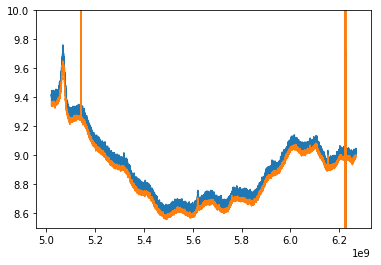

In [20]:
plot(freqs, rrls)
plot(freqs, offdata)
ylim(8.5, 10)

(-0.05, 0.14)

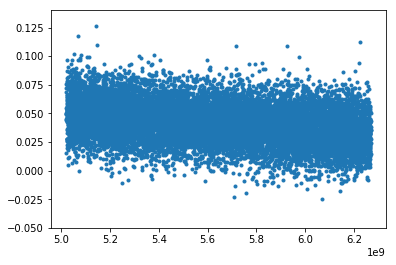

In [21]:
plot(freqs, rrls - offdata, '.')
ylim(-0.05, 0.14)

In [11]:
rrls = np.nanmean(cdata, 0)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


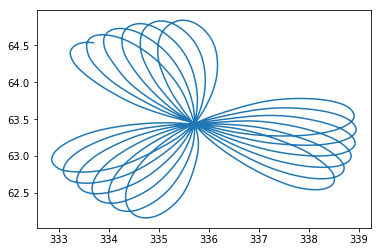

In [19]:
plot(ra, dec)

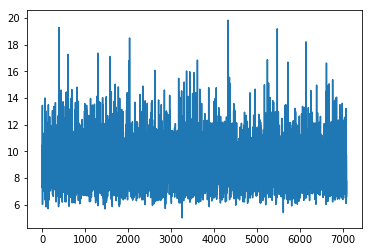

In [17]:
plot(cdata[:, 5000])

In [12]:
rrls.shape

(16384,)

(8.5, 10)

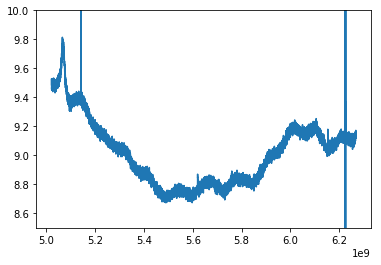

In [15]:
plot(freqs[mask], rrls[mask])
ylim(8.5, 10)

In [ ]:
xxoff[:, ~mask] = np.nan

ratio = np.zeros(N)
ratio[mask] = np.nanstd(xxoff[:, mask], 0) / np.nanmean(xxoff[:, mask], 0)
ratio[~mask] = np.nan
ratio_mad = 5. / 0.67449 * mad(ratio[mask])
bad = np.zeros_like(mask)
bad[mask] = np.abs(ratio[mask] - np.nanmean(ratio[mask])) > ratio_mad
mask[bad] = False
xxoff[:, ~mask] = np.nan

msdata = np.zeros_like(xxoff)
msdata[:, mask] = xxoff[:, mask] - np.nanmean(xxoff[:, mask], 0)
msdata[:, ~mask] = np.nan

speck = np.zeros(xxoff.shape[1])
speck[mask] = np.nanmean((msdata[:, mask]**4), 0) / np.nanmean((msdata[:, mask]**2), 0)**2
speck[~mask] = np.nan
speck_mad = 5. / 0.67449 * mad(speck[mask])
bad = np.zeros_like(mask)
bad[mask] = np.abs(speck[mask] - np.nanmean(speck[mask])) > speck_mad
mask[bad] = False

In [5]:
def get_data(bank='A', session=5):
    fnames = glob.glob('/data2/GBT/S140/Daisy/*/*_0'+str(session)+'_*'+bank+'*.rfireduced_new.npz')
    fnames.sort()
    calibrations = np.load('/home/mabitbol/GBT-S140/calibrations/calibration_3C295_0'+str(session)+'_'+bank+'.npy').item()
    fdiode = calibrations['freqs']
    pdiode = calibrations['pdiode']
    pdiode1 = calibrations['pdiode1']
    meanpower = 0.5 * (pdiode + pdiode1)
    spectrum = np.zeros(512)
    sums = np.zeros(512)
    for fname in fnames:
        nz = np.load(fname)
        mask = nz['valid']
        gain = meanpower / ( nz['xxon'] - nz['xxoff'])
        calibd = nz['xxoff'] * gain
        
        mask[:200] = False
        mask[400:] = False
    
        calibd = calibd[:, mask]
        spectrum[mask] += np.nanmean(calibd, 0)
        sums[mask] += 1
    return spectrum, sums

In [4]:
def mad(x, axis=None):
    return np.nanmedian(np.abs(x - np.nanmedian(x, axis)), axis)